# Multi-armed Bandits
An implementation of the $k$-armed bandit problem with greedy and $\varepsilon$-greedy action selection methods as described in Chapter 2 of _Reinforcement Learning: An Introduction, 2nd Edition (2018)_ by Richard S. Sutton and Andrew G. Barto.

The "10-armed testbed" described in the book is reproduced for an ensemble of bandits and the average performance is plot for a number of values of $\varepsilon$. 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
class KArmedBandit:
    """
    Class implementing a k-armed bandit.
    
    For each of the k actions, the expected action is initialised from a
    Gaussian distribution with mean 0 and unit variance.
    
    The reward for each action is then selected from a Gaussian distribution
    with mean of the expected action and unit variance.
    
    Args:
        k (int, default=10): Number of actions (arms)
    Atributes:
        q_a (1D array of floats): List of expected action values with length k
    """
    
    def __init__(self, k=10):
        """
        Initialise expected action values
        """
        self.k = k
        self.q_a = np.random.normal(0.0, 1.0, k)
    
    def reward(self, action):
        """
        Generate reward for a particular action.
        
        Args:
            action (int): Integer action from 0 to k-1
        """
        return np.random.normal(self.q_a[action], 1.0)

In [3]:
class NonStationaryKArmedBandit(KArmedBandit):
    """
    From Exercise 2.5.
    
    Class implementing a K-armed bandit with non-stationary probability
    distributions, whereby at each call to reward, the expected action is shifted
    by an amount drawn from a Gaussian distribution with zero mean and standard
    deviation 0.01
    """
    
    def reward(self, action):
        """
        Generate reward then shift expected reward values
        """
        reward = np.random.normal(self.q_a[action], 1.0)
        
        shift_array = np.random.normal(0.0, 0.01, self.k)
        self.q_a += shift_array
        
        return reward            

In [31]:
class GreedyAgent:
    """
    Class implementing an agent using greedy or epsilon-greedy action-value methods
    
    Args:
        bandit: An instance of a KArmedBandit. This will be the bandot from which
            the agent acts on and draws rewards
        epsilon (optional float [0,1], default None): Parameter for epsilon-greedy
            action value method. If None, a greedy method will be used.
        log_expected_reward (optional): Log expected rewards
        constant_step_size (optional, float (0,1]): Use constant step size for
            reward estimates, otherwise use sample average.
    Attributes:
        Qn: array of expected rewards for actions 1 to k at the nth step
        steps: number of steps performed
        accumulated_reward: total reward accumulated at current timestep
    """
    
    def __init__(self, bandit, epsilon=None, log_expected_rewards=True,
                 constant_step_size=None):

        self.bandit = bandit
        self.k = bandit.k
        self.Qn = np.zeros(self.k)
        self.steps = 0
        self.accumulated_reward = [0.0]
        self.epsilon = epsilon
        self.action_log = []
        self.expected_reward_log = self.Qn
        self.times_chosen = np.zeros(self.k)
        self.log_expected_rewards = log_expected_rewards
        self.constant_step_size = constant_step_size
    
    def perform_action(self):
        """
        Select an action to perform, obtain reward and update expected rewards,
        steps and accumulated reward
        
        Return:
            action, reward value
        """
        if self.steps == 0:
            # randomly choose an initial action
            a = np.random.randint(0, self.k)
        else:
            # choose action corresponding to largest expected reward
            a = np.argmax(self.Qn)
        if self.epsilon:
            if np.random.rand() < self.epsilon:
                # print(f'step: {self.steps}, exporatory move')
                a = np.random.randint(0, self.k)
        
        reward = self.bandit.reward(a)
        self.action_log.append(a)
        
        self.steps += 1
        self.accumulated_reward.append(self.accumulated_reward[-1] + reward)
        # update expected reward
        self.times_chosen[a] += 1.0

        if self.constant_step_size:
            step_size = self.constant_step_size
        else:
            step_size = 1. / self.times_chosen[a]
            
        self.Qn[a] += step_size * (reward - self.Qn[a])

        if self.log_expected_rewards:
            self.expected_reward_log = np.vstack((self.expected_reward_log, self.Qn))
        return a, reward

## A single agent
A 10-armed bandit implementation with greedy action selection and $\epsilon=0.1$ greedy action selection with 10000 steps. The expected values for each action is plot for each action-value method. The expected action values are initialised to zero for both agents. 

In [5]:
bandit = KArmedBandit()
agent = GreedyAgent(bandit)

In [6]:
for i in range(10000):
    agent.perform_action()

<IPython.core.display.Javascript object>


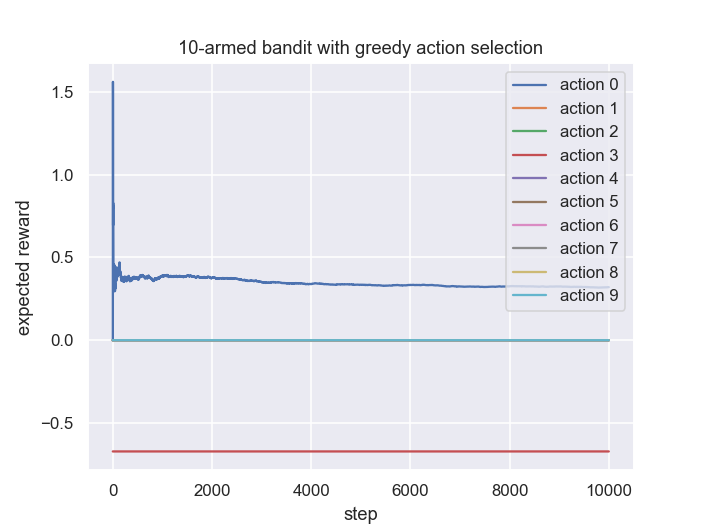

In [7]:
for idx in range(bandit.k):
    plt.plot(agent.expected_reward_log[:, idx], label=f'action {idx}')
plt.title('10-armed bandit with greedy action selection')
plt.ylabel('expected reward')
plt.xlabel('step')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


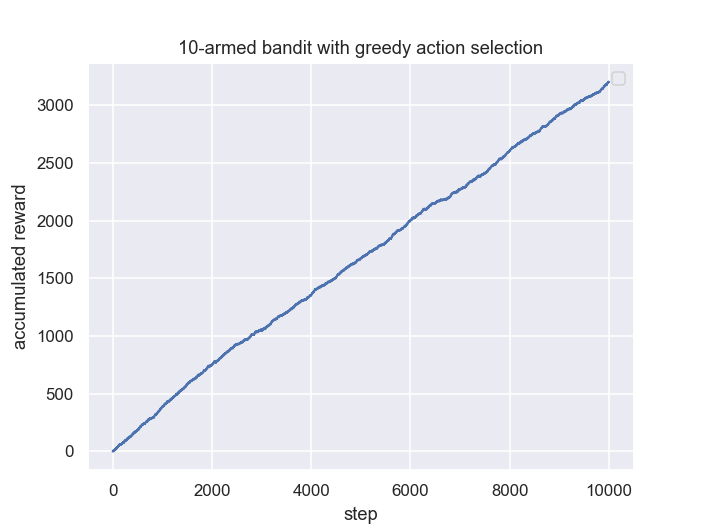

No handles with labels found to put in legend.


In [8]:
plt.plot(agent.accumulated_reward)
plt.title('10-armed bandit with greedy action selection')
plt.ylabel('accumulated reward')
plt.xlabel('step')
plt.legend(loc='upper right')

Actual expected reward values

In [9]:
bandit.q_a

array([ 0.31595081,  1.51382322, -0.13031386, -1.75586426,  0.20704261,
       -0.82427752, -1.24562669,  0.55306703,  0.30678339, -0.5812507 ])

In [10]:
agent = GreedyAgent(bandit, epsilon=0.1)

In [11]:
for i in range(10000):
    agent.perform_action()

Evolution of expected reward values with $\varepsilon=0.1$

<IPython.core.display.Javascript object>


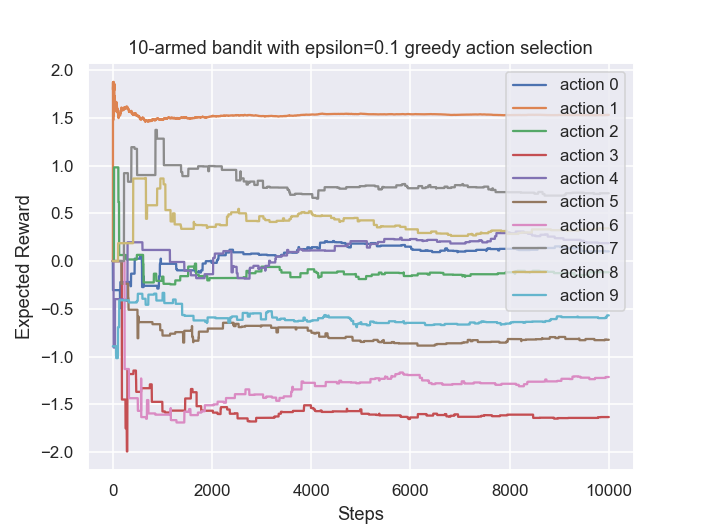

In [14]:
for idx in range(bandit.k):
    plt.plot(agent.expected_reward_log[:, idx], label=f'action {idx}')
plt.title('10-armed bandit with epsilon=0.1 greedy action selection')
plt.ylabel('Expected Reward')
plt.xlabel('Steps')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


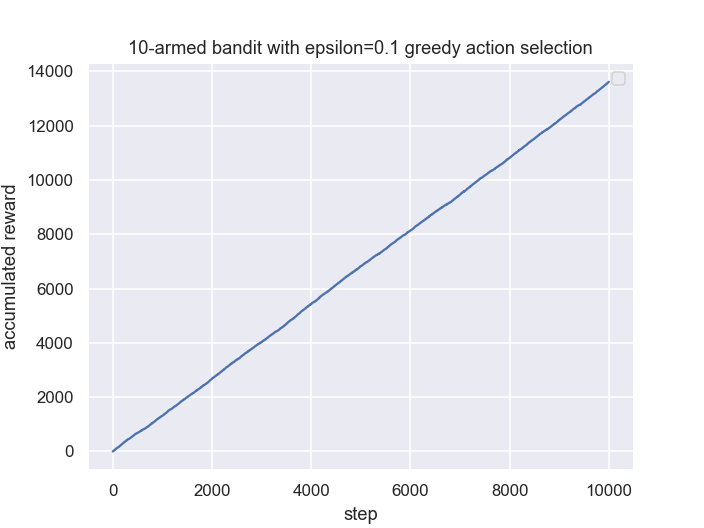

No handles with labels found to put in legend.


In [15]:
plt.plot(agent.accumulated_reward)
plt.title('10-armed bandit with epsilon=0.1 greedy action selection')
plt.ylabel('accumulated reward')
plt.xlabel('step')
plt.legend(loc='upper right')

## Ensemble of bandits

Define an ensemble of 2000 bandit problems and investigate the average performance over a number of steps. This is the "10-armed testbed" decribed in chapter 2.

In [50]:
class Ensemble:
    """
    An ensemble of N k-armed bandit problems.
    
    Args:
        N: Number of bandits
        k: Number of actions
        epsilon: epsilon value for epsilon greedy action method
        nonstationary (optional, default False): Use nonstationary bandits
        constant_step_size (optional, float (0,1], default None): Use constant
            step size for reward estimates
        log_expected_rewards: optionally log expected rewards
        random_seed (optional, int): Set random seed for reproducibility 
    
    Attributes:
        bandits: List of KArmedBandit instances
        agents: List of agents. Each agent is assigned to a bandit
        steps: number of steps performed
        average_rewards: List of average reward values over all agents at each step
        fraction_optimal_action: Fraction of agents performing optimal action at each
            step
    """
    
    def __init__(self, N=2000, k=10, epsilon=None, nonstationary=False, 
                 constant_step_size=None, log_expected_rewards=False, random_seed=None):
        
        if random_seed:
            np.random.seed(random_seed)

        self.N = N
        self.k = k
        self.epsilon = epsilon
        bandit_type = KArmedBandit if not nonstationary else NonStationaryKArmedBandit
        self.bandits = [bandit_type(k=k) for _ in range(N)]
        self.agents = [
            GreedyAgent(bandit=bandit, epsilon=epsilon, log_expected_rewards=False,
                        constant_step_size=constant_step_size)
            for bandit in self.bandits
        ]
        self.steps = 0
        self.average_rewards = []
        self.fraction_optimal_actions = []
        self.constant_step_size = constant_step_size
        
    def reinitialize_agents(self, epsilon=None):
        """
        Keep ensemble of bandits but reset steps and reinitialise agents
        """
        self.agents = [
            GreedyAgent(bandit=bandit, epsilon=epsilon, log_expected_rewards=False,
                constant_step_size=self.constant_step_size)
            for bandit in self.bandits
        ]
        self.steps = 0
        self.average_rewards = []
        self.fraction_optimal_actions = []
    
    def perform_actions(self, n_steps):
        """
        Perform action for n_steps, updating average rewards and optimal actions
        """
        for _ in range(n_steps):
            actions = []
            rewards = []
            for agent in self.agents:
                action, reward = agent.perform_action()
                rewards.append(reward)
                actions.append(action)
                # print(reward, action)
            
            fraction_optimal_action = np.sum([
                1 for agent, action in zip(self.agents, actions)
                if action == np.argmax(agent.bandit.q_a)
            ]) / self.N
            self.fraction_optimal_actions.append(fraction_optimal_action)
            self.average_rewards.append(np.mean(rewards))
            self.steps += 1
            if not self.steps % 100:
                # print(self.bandits[0].q_a)
                print(f'steps: {self.steps}')

Create ensemble of bandits

In [17]:
ensemble = Ensemble()

Perform actions for greedy action method ($\varepsilon=0.0$)

In [15]:
ensemble.perform_actions(2000)
average_rewards_greedy = ensemble.average_rewards
optimal_actions_greedy = ensemble.fraction_optimal_actions

steps: 100
steps: 200
steps: 300
steps: 400
steps: 500
steps: 600
steps: 700
steps: 800
steps: 900
steps: 1000
steps: 1100
steps: 1200
steps: 1300
steps: 1400
steps: 1500
steps: 1600
steps: 1700
steps: 1800
steps: 1900
steps: 2000


Reinitialise agents and perform actions for $\varepsilon=0.1$

In [16]:
ensemble.reinitialize_agents(epsilon=0.1)
ensemble.perform_actions(2000)
average_rewards_01 = ensemble.average_rewards
optimal_actions_01 = ensemble.fraction_optimal_actions

steps: 100
steps: 200
steps: 300
steps: 400
steps: 500
steps: 600
steps: 700
steps: 800
steps: 900
steps: 1000
steps: 1100
steps: 1200
steps: 1300
steps: 1400
steps: 1500
steps: 1600
steps: 1700
steps: 1800
steps: 1900
steps: 2000


Reinitialise agents and perform actions for $\varepsilon=0.01$

In [17]:
ensemble.reinitialize_agents(epsilon=0.01)
ensemble.perform_actions(2000)
average_rewards_001 = ensemble.average_rewards
optimal_actions_001 = ensemble.fraction_optimal_actions

steps: 100
steps: 200
steps: 300
steps: 400
steps: 500
steps: 600
steps: 700
steps: 800
steps: 900
steps: 1000
steps: 1100
steps: 1200
steps: 1300
steps: 1400
steps: 1500
steps: 1600
steps: 1700
steps: 1800
steps: 1900
steps: 2000


Plot average rewards for each action value method

<IPython.core.display.Javascript object>


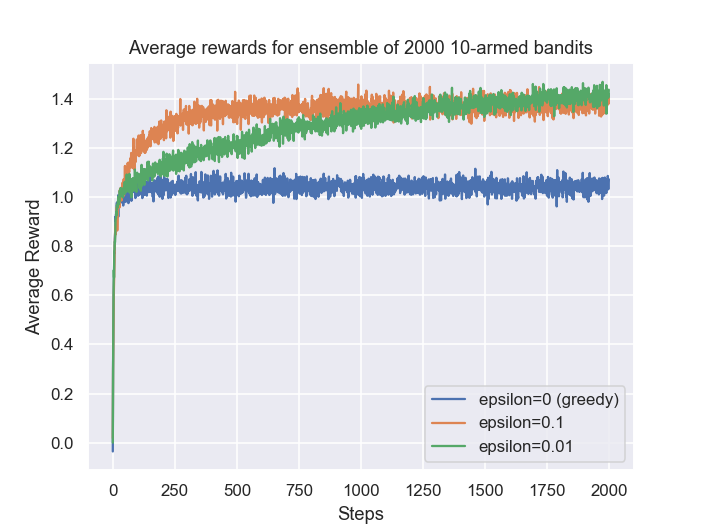

In [18]:
plt.plot(average_rewards_greedy, label='epsilon=0 (greedy)')
plt.plot(average_rewards_01, label='epsilon=0.1')
plt.plot(average_rewards_001, label='epsilon=0.01')
plt.title('Average rewards for ensemble of 2000 10-armed bandits')
plt.ylabel('Average Reward')
plt.xlabel('Steps')
plt.legend(loc='lower right')

In [19]:
max_average_reward = np.mean([np.max(bandit.q_a) for bandit in ensemble.bandits])

print(f'Highest possible average reward = {max_average_reward}')

Highest possible average reward = 1.5381638379306806


The above figure shows that the average reward value of the greedy method plateaus around 1.0. The methods with non-zero $\varepsilon$ values are able to achieve a higher average reward, with the maximum average reward being 1.54. The lower value of $\varepsilon=0.01$ is able to achieve a greater average reward because it samples the optimal action more often than the $\varepsilon=0.1$ method. 

<IPython.core.display.Javascript object>


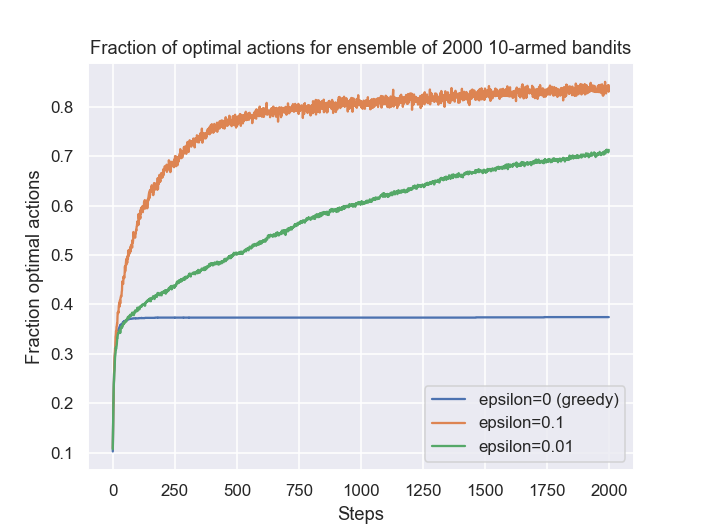

In [20]:
plt.plot(optimal_actions_greedy, label='epsilon=0 (greedy)')
plt.plot(optimal_actions_01, label='epsilon=0.1')
plt.plot(optimal_actions_001, label='epsilon=0.01')
plt.title('Fraction of optimal actions for ensemble of 2000 10-armed bandits')
plt.ylabel('Fraction optimal actions')
plt.xlabel('Steps')
plt.legend(loc='lower right')

## Exercise 2.5 - Non-stationary bandits

Now the performance of $\varepsilon$-greedy action-value methods will be computed for 10-armed bandits with non-stationary reward distributions. The case of sample averaged reward estimates will be compared with constant step size updating with $\alpha=0.1$.

Ensemble of non-stationary bandits with sample averaged reward estimates  

In [48]:
ensemble_nonstationary = Ensemble(
    nonstationary=True, epsilon=0.1, random_seed=42)

In [49]:
ensemble_nonstationary.perform_actions(10000)
average_rewards_sample_average = ensemble_nonstationary.average_rewards
optimal_actions_sample_average = ensemble_nonstationary.fraction_optimal_actions

steps: 100
steps: 200
steps: 300
steps: 400
steps: 500
steps: 600
steps: 700
steps: 800
steps: 900
steps: 1000
steps: 1100
steps: 1200
steps: 1300
steps: 1400
steps: 1500
steps: 1600
steps: 1700
steps: 1800
steps: 1900
steps: 2000
steps: 2100
steps: 2200
steps: 2300
steps: 2400
steps: 2500
steps: 2600
steps: 2700
steps: 2800
steps: 2900
steps: 3000
steps: 3100
steps: 3200
steps: 3300
steps: 3400
steps: 3500
steps: 3600
steps: 3700
steps: 3800
steps: 3900
steps: 4000
steps: 4100
steps: 4200
steps: 4300
steps: 4400
steps: 4500
steps: 4600
steps: 4700
steps: 4800
steps: 4900
steps: 5000
steps: 5100
steps: 5200
steps: 5300
steps: 5400
steps: 5500
steps: 5600
steps: 5700
steps: 5800
steps: 5900
steps: 6000
steps: 6100
steps: 6200
steps: 6300
steps: 6400
steps: 6500
steps: 6600
steps: 6700
steps: 6800
steps: 6900
steps: 7000
steps: 7100
steps: 7200
steps: 7300
steps: 7400
steps: 7500
steps: 7600
steps: 7700
steps: 7800
steps: 7900
steps: 8000
steps: 8100
steps: 8200
steps: 8300
steps: 8400
s

Ensemble of non-stationary bandits with constant step size reward estimates  

In [51]:
ensemble_nonstationary = Ensemble(
    nonstationary=True, epsilon=0.1, random_seed=42, constant_step_size=0.1)

In [52]:
ensemble_nonstationary.perform_actions(10000)
average_rewards_constant = ensemble_nonstationary.average_rewards
optimal_actions_constant = ensemble_nonstationary.fraction_optimal_actions

steps: 100
steps: 200
steps: 300
steps: 400
steps: 500
steps: 600
steps: 700
steps: 800
steps: 900
steps: 1000
steps: 1100
steps: 1200
steps: 1300
steps: 1400
steps: 1500
steps: 1600
steps: 1700
steps: 1800
steps: 1900
steps: 2000
steps: 2100
steps: 2200
steps: 2300
steps: 2400
steps: 2500
steps: 2600
steps: 2700
steps: 2800
steps: 2900
steps: 3000
steps: 3100
steps: 3200
steps: 3300
steps: 3400
steps: 3500
steps: 3600
steps: 3700
steps: 3800
steps: 3900
steps: 4000
steps: 4100
steps: 4200
steps: 4300
steps: 4400
steps: 4500
steps: 4600
steps: 4700
steps: 4800
steps: 4900
steps: 5000
steps: 5100
steps: 5200
steps: 5300
steps: 5400
steps: 5500
steps: 5600
steps: 5700
steps: 5800
steps: 5900
steps: 6000
steps: 6100
steps: 6200
steps: 6300
steps: 6400
steps: 6500
steps: 6600
steps: 6700
steps: 6800
steps: 6900
steps: 7000
steps: 7100
steps: 7200
steps: 7300
steps: 7400
steps: 7500
steps: 7600
steps: 7700
steps: 7800
steps: 7900
steps: 8000
steps: 8100
steps: 8200
steps: 8300
steps: 8400
s

<IPython.core.display.Javascript object>


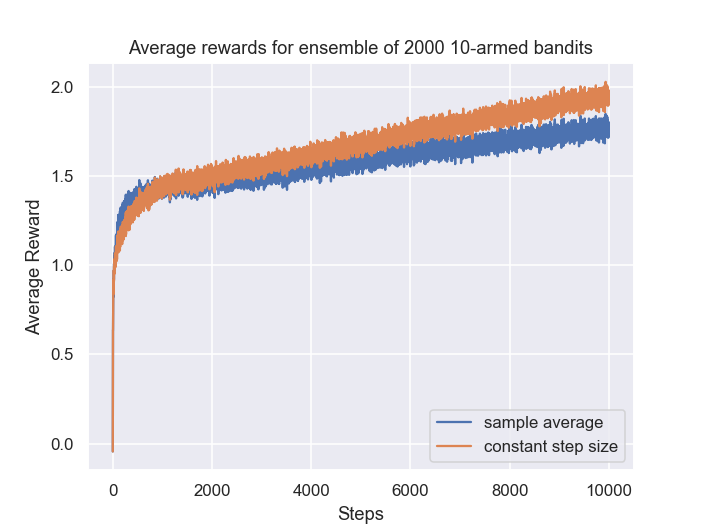

In [53]:
plt.plot(average_rewards_sample_average, label='sample average')
plt.plot(average_rewards_constant, label='constant step size')
plt.title('Average rewards for ensemble of 2000 10-armed bandits')
plt.ylabel('Average Reward')
plt.xlabel('Steps')
plt.legend(loc='lower right')

<IPython.core.display.Javascript object>


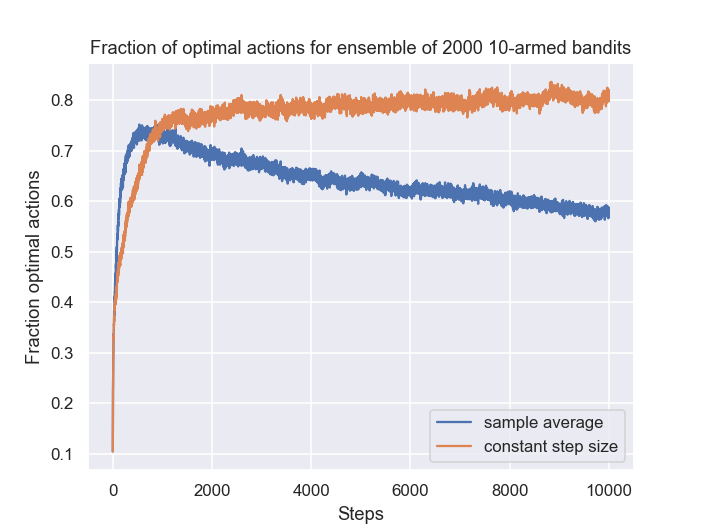

In [54]:
plt.plot(optimal_actions_sample_average, label='sample average')
plt.plot(optimal_actions_constant, label='constant step size')
plt.title('Fraction of optimal actions for ensemble of 2000 10-armed bandits')
plt.ylabel('Fraction optimal actions')
plt.xlabel('Steps')
plt.legend(loc='lower right')

We can see that in the case of non-stationary bandits the performance of the sample average action-method yields lower average rewards in the long run than the constant timestep method. This is shown more starkly in the plot showing the fraction of optimal decisions. It can be seen that the this decreases at long times for the sample average method, since the estimate of the reward is equally weighted among all time steps, despite the fact that the actual action rewards will have diverged significantly from their early values. In the case of the constant time step method, the fraction of optimal actions is slower to increase but remains increasing while plateauing at around 0.8.